```
SOW-MKI95 Computer Graphics & Computer Vision Spring 2020
Dr. Umut Güçlü
Lab 13: Variational autoencoders
05-06-2020
```
```
Group number: 8
Chris Beem: s1044334
Nolan Cardozo: s1034065
Ajinkya Indulkar: s1034517
```

In [1]:
# import mxnet libraries
from mxnet import autograd, nd, gluon
from mxnet.gluon import nn

import matplotlib.pyplot as plt
import mxnet as mx
import mxnet.ndarray as nd
import numpy as np
from tqdm.notebook import tqdm

from scipy.special import ndtri
from scipy.stats import norm

%matplotlib inline

# set random seed (deterministic behaviour)
mx.random.seed(43)
np.random.seed(43)

Set Notebook Device

In [2]:
def gpu_exists():
    '''function to check GPU availability'''
    try:
        mx.nd.zeros((1,), ctx=mx.gpu(0))
    except:
        return False
    return True

data_ctx = mx.cpu()
if gpu_exists():
    print('Using GPU for model_ctx')
    model_ctx = mx.gpu(0)
else:
    print('Using CPU for model_ctx')
    model_ctx = mx.cpu()

Using CPU for model_ctx


In [3]:
# Global parameters
BATCH_SIZE = 100
N_HIDDEN   = 400
N_LATENT   = 2
N_LAYERS   = 1
N_OUTPUT   = 784
N_EPOCH    = 50
model_pfx  = 'vae_{}d{}l{}h.params'.format(N_LATENT, N_LAYERS, N_HIDDEN)

### Task 1 (10 points):

* Implement the decoder class for a variational autoencoder.

---o---

Recall that the decoder transforms latents (features) to observables (images). It corresponds to p(x | z) in the context of variational inference (and the slides), where x is observables and z is latents. Note that it should output the Gaussian parameters (mean and variance per pixel) of images rather than images themselves.

---o---

### Task 2 (10 points):

* Implement the encoder class for a variational autoencoder.

---o---

Recall that the encoder transforms observables (images) to latents (features). It corresponds to q(z | x) in the context of variational inference (and the slides), where z is latents and x is observables. Note that it should output the Gaussian parameters (mean and variance per feature) of features rather than features themselves.

---o---

### Task:

* Implement the loss function class for a variational autoecoder.

---o---

The loss function takes the following arguments as input:

* x        : input images (mini batch)
* x_mean   : mean of the decoded images (output of the decoder)
* x_log_var: mean of the decoded images (output of the decoder)
* z_mean   : mean of the encoded features (output of the encoder)
* z_log_var: log variance of the encoded features (output of the encoder)

It gives the following evidence lower bound (ELBO) as ouput:

* $L = D_{KL}(q(z | x), p(z)) -  E_{z\sim q}[log p(x | z)]$

where

* The first term is the KL divergence between the approximate Gaussian posterior (q) and the standard Gaussian prior (p), which can be interpreted as a form of regularization.
* The second term is the Gaussian negative log likelihood, which is the term that fits the data and is very similar to the usual loss functions that are usded in deep learning.

---o---

In [140]:
class ELBOLoss:
    # Feel free to use different w which can be used as the weight of the different loss components
    def __init__(self, w = 1.0): 
        self.w = w
        self.soft_zero = 1e-10

    def __call__(self, x, x_mean, x_log_var, z_mean, z_log_var):
        # Your code here...
#         compute Gaussian negative log likelihood: F.sum(x*F.log(y+self.soft_zero)+ (1-x)*F.log(1-y+self.soft_zero), 
#                                                         axis=1)
        logloss = 0
        # compute KL Divergence: 0.5*F.sum(1+lv-mu*mu-F.exp(lv),axis=1)
        KL = 0
        # compute ELBO
        loss = -logloss-KL
        return loss * self.w

In [150]:
class Encoder(nn.HybridSequential):
    def __init__(self, activation = "relu", hiddens= 400, latents = 2, layers = 1, **kwargs): # Feel free to use different arguments
        super(Encoder, self).__init__(**kwargs)
        self.activation = activation
        self.hiddens = hiddens
        self.latents = latents
        self.layers = layers
        self.add(nn.Dense( self.hiddens, activation=self.activation, in_units = 28*28))
        for i in range(self.layers):
            self.add(nn.Dense(self.hiddens, activation=self.activation))
        self.add(nn.Dense(self.latents*2, activation=None))

In [157]:
class Decoder(nn.HybridSequential):
    def __init__(self, activation = "relu", hiddens = 400, observables = 784, layers = 1, **kwargs): 
        super(Decoder, self).__init__(**kwargs)
        self.activation = activation
        self.hiddens = hiddens
        self.observables = observables
        self.layers = layers
        #self.prefix = 'decoder_prefix'
        #self.add(nn.Dense( self.hiddens, activation=self.activation, in_units = 123456))
        for i in range(self.layers):
            self.add(nn.Dense(self.hiddens, activation=self.activation))
        self.add(nn.Dense(self.observables, activation='sigmoid'))

### Task (5 points):

* Implement the variational autoencoder.

In [ ]:
class VariationalAutoencoder(gluon.HybridBlock):
    # Feel free to use different arguments
    def __init__(self,  activation = "relu", hiddens= 400, latents = 2, observables = 784, layers = 1, batch_size =BATCH_SIZE, **kwargs): 
        super(VariationalAutoencoder, self).__init__()
        with self.name_scope():
            self.encoder = Encoder(activation, hiddens, latents, layers, **kwargs)
            self.decoder = Decoder(activation, hiddens, observables, layers, **kwargs)
            self.batch_size = batch_size
            self.latents = latents
            self.almost_zero = 1e-8

    def hybrid_forward(self, F, x):
        # Your code here...
        
        #print("X: = ",x.infer_shape())
        h = self.encoder(x)
        #print("H: = ",h.infer_shape())
        #print(h)
        mu_lv = F.split(h, axis=1, num_outputs=2)
        mu = mu_lv[0]
        lv = mu_lv[1]
        self.mu = mu
        #eps = F.random_normal(loc=0, scale=1, shape=mu.shape, ctx=model_ctx)
        # this would work fine only for nd (i.e. non-hybridized block)
        
        
        eps = F.random_normal(loc=0, scale=1, shape=(self.batch_size, self.latents), ctx=model_ctx)
        z = mu + F.exp(0.5*lv)*eps
        y = self.decoder(z)
        self.output = y

        KL = 0.5*F.sum(1+lv-mu*mu-F.exp(lv),axis=1)
        logloss = F.sum(x*F.log(y+self.almost_zero)+ (1-x)*F.log(1-y+self.almost_zero), axis=1)
        loss = -logloss-KL
        
        print("LOSS:",loss)
        return loss
        
        #return loss
        
        
        x_mean = F.mean(x)
        x_log_var = x_mean
        z_mean =x_mean
        z_log_var = x_mean
        return lv, lv, lv, lv

### Task (25 points):

* Train the variational autoencoder on the Mnist dataset. You can refer to the previous assignment to implement your training loop.

#### Load MNIST Data

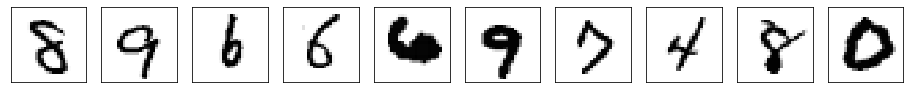

In [125]:
mnist = mx.test_utils.get_mnist()

n_samples = 10
idx = np.random.choice(len(mnist['train_data']), n_samples)
_, axarr = plt.subplots(1, n_samples, figsize=(16,4))
for i,j in enumerate(idx):
    axarr[i].imshow(mnist['train_data'][j][0], cmap='Greys')
    axarr[i].get_xaxis().set_ticks([])
    axarr[i].get_yaxis().set_ticks([])
plt.show()

In [10]:
# inspect dataset
print("Train - Number of samples: {} | shape of samples: {} | shape of labels: {}".format(mnist['train_data'].shape[0],
                                                                                         mnist['train_data'].shape,
                                                                                         mnist['train_label'].shape))
print("Test - Number of samples: {} | shape of samples: {} | shape of labels: {}".format(mnist['test_data'].shape[0],
                                                                                         mnist['test_data'].shape,
                                                                                         mnist['test_label'].shape))

Train - Number of samples: 60000 | shape of samples: (60000, 1, 28, 28) | shape of labels: (60000,)
Test - Number of samples: 10000 | shape of samples: (10000, 1, 28, 28) | shape of labels: (10000,)


In [11]:
# reshape train and test sets
train_data = np.reshape(mnist['train_data'],(-1,28*28))
test_data = np.reshape(mnist['test_data'],(-1,28*28))

# define data loaders
n_batches = train_data.shape[0]/BATCH_SIZE
train = mx.io.NDArrayIter(data={'data': train_data}, label={'label': mnist['train_label']}, 
                               batch_size = BATCH_SIZE)
test  = mx.io.NDArrayIter(data={'data': test_data}, label={'label': mnist['test_label']}, 
                              batch_size = BATCH_SIZE)


#### Train Model

In [165]:
# define model
net = VariationalAutoencoder(hiddens=N_HIDDEN, latents=N_LATENT, observables=28*28, layers=N_LAYERS)
# initialize model

net.collect_params().initialize(mx.init.Xavier(), ctx=model_ctx)
net.hybridize()
# define optimizer and loss criterion
trainer = gluon.Trainer(net.collect_params(), 'adam', {'learning_rate': .001})
criterion = ELBOLoss()

import time

print_period = N_EPOCH // 10
start = time.time()
training_loss = []
validation_loss = []

# train over N_EPOCH
for epoch in tqdm(range(N_EPOCH), desc='epochs'):
    epoch_loss = 0
    epoch_val_loss = 0
    
    # reset data loaders
    train.reset()
    test.reset()
    
    # iterate over train data and update model
    n_batch_train = 0
    
    
    for batch in train:
        n_batch_train +=1
        # fetch data
        data = batch.data[0].as_in_context(model_ctx)
    
        with autograd.record():
            # feed-forward function
            #print("SHAPE DATA 2",data.shape)
            
            loss = net(data) 
            # compute loss
            #loss = criterion(data, x_mean, x_log_var, z_mean, z_log_var) 
        # backprop
        loss.backward() 
        # optimizer step
        trainer.step(data.shape[0]) 
        epoch_loss += nd.mean(loss).asscalar()
    
    # iterate over test data and compute loss
    n_batch_val = 0
    for batch in test:
        n_batch_val +=1
        data = batch.data[0].as_in_context(model_ctx)
        loss = net(data)
        epoch_val_loss += nd.mean(loss).asscalar()

    # normalize losses
    epoch_loss /= n_batch_train
    epoch_val_loss /= n_batch_val
    
    # save losses
    training_loss.append(epoch_loss)
    validation_loss.append(epoch_val_loss)

    # print training logs
    if epoch % max(print_period,1) == 0:
        tqdm.write('Epoch{}, Training loss {:.2f}, Validation loss {:.2f}'.format(epoch, epoch_loss, epoch_val_loss))

end = time.time()
print('Time elapsed: {:.2f}s'.format(end - start))

LOSS: <Symbol variationalautoencoder49__minus2>
Epoch0, Training loss 195.76, Validation loss 175.52
Epoch5, Training loss 160.31, Validation loss 160.88
Epoch10, Training loss 154.20, Validation loss 155.33
Epoch15, Training loss 151.88, Validation loss 152.52
Epoch20, Training loss 149.83, Validation loss 151.08
Epoch25, Training loss 148.66, Validation loss 149.97
Epoch30, Training loss 147.47, Validation loss 149.11
Epoch35, Training loss 146.31, Validation loss 147.81
Epoch40, Training loss 145.50, Validation loss 147.35
Epoch45, Training loss 145.08, Validation loss 146.58

Time elapsed: 850.67s


In [166]:
# save model
net.save_parameters(model_pfx)

#### Plot Training

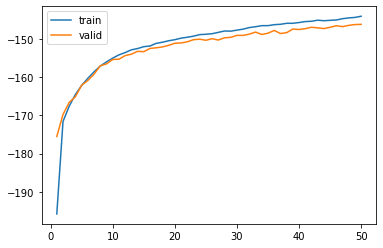

In [168]:
batch_x = np.linspace(1, N_EPOCH, len(training_loss))
plt.figure()
plt.plot(batch_x, -1*np.array(training_loss))
plt.plot(batch_x, -1*np.array(validation_loss))
plt.legend(['train', 'valid'])
plt.show()

### Task (50 points):
* Evaluate the reconstruction quality of the variational autoencoder: Draw some Mnist like images, encode them, decode them, visualize them and briefly explain the results.
 * Repeat the task with drawings of something else (e.g., a face).
* Evaluate the sampling quality of the variational autoencoder: Sample some random features from the prior, decode them, visualize them and briefly explain the results.
 * Repeat the task with features on a regular grid.
* Evaluate the latent quality of the variational autoencoder: Scatter plot features of images, color code their labels.

In [169]:
# load model
net2 = VariationalAutoencoder(hiddens=N_HIDDEN, latents=N_LATENT, observables=N_OUTPUT, layers=N_LAYERS)
net2.load_parameters(model_pfx, ctx=model_ctx)

#### Visualizing Reconstruction Quality

In [172]:
# reset test data loader
test.reset()
# fetch first batch from data loader
test_batch = test.next()
# pass test batch input through the network
net2(test_batch.data[0].as_in_context(model_ctx))
# fetch output
result = net2.output.asnumpy() # CHANGE THIS
original = test_batch.data[0].asnumpy()

LOSS: 
[ 90.91534  220.02016   43.087242 146.5924   129.61024   49.90265
 211.6279   182.19438  274.18253  169.01657  156.21736  204.6744
 103.56889  138.17712   48.238213 177.95938  123.22428  119.558304
 207.17625  110.93808  103.905174 118.47424  179.18167  150.39575
 124.836006 222.78722  131.91954  122.79916  127.82066   60.365204
 159.93976   61.215385 145.69395  294.02124  116.46396  205.70633
 144.79813   53.081726 234.883     51.285957  49.446564 123.06066
 140.2546   241.3098   155.66537  147.70114  122.51636  178.54234
 178.05815  139.3906   103.74102  177.13548  178.5911   167.0799
 203.01086  135.70572  147.33827   41.498398 119.42729  148.2438
 194.32385  198.24666  112.992065 189.00214  263.73074  106.18084
 210.35756  152.44815  148.84521  182.75693  128.17459  125.880394
 251.56218  126.5092    60.237465 184.2723   136.37044  192.4262
 127.67206  149.65802  107.69317  125.631905 138.91765  102.148735
 189.41438  176.5917   110.3602   203.72424  143.79655   60.444725
 1

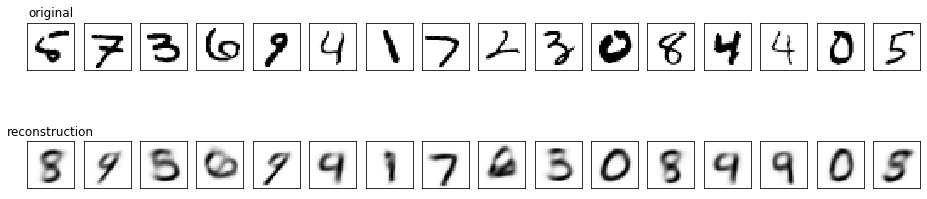

In [180]:
n_samples = 16
idx = np.random.choice(BATCH_SIZE, n_samples)
_, axarr = plt.subplots(2, n_samples, figsize=(16,4))
for i,j in enumerate(idx):
    axarr[0,i].imshow(original[j].reshape((28,28)), cmap='Greys')
    if i==0:
        axarr[0,i].set_title('original')
    #axarr[0,i].axis('off')
    axarr[0,i].get_xaxis().set_ticks([])
    axarr[0,i].get_yaxis().set_ticks([])

    axarr[1,i].imshow(result[j].reshape((28,28)), cmap='Greys')
    if i==0:
        axarr[1,i].set_title('reconstruction')
    #axarr[1,i].axis('off')
    axarr[1,i].get_xaxis().set_ticks([])
    axarr[1,i].get_yaxis().set_ticks([])
plt.show()

Load New Dataset and observe reconstruction

#### Sample latent space and generate images
Random sampling

In [205]:
n_samples = 50
zsamples = nd.array(np.random.randn(n_samples*n_samples, N_LATENT))
images = net2.decoder(zsamples.as_in_context(model_ctx)).asnumpy()

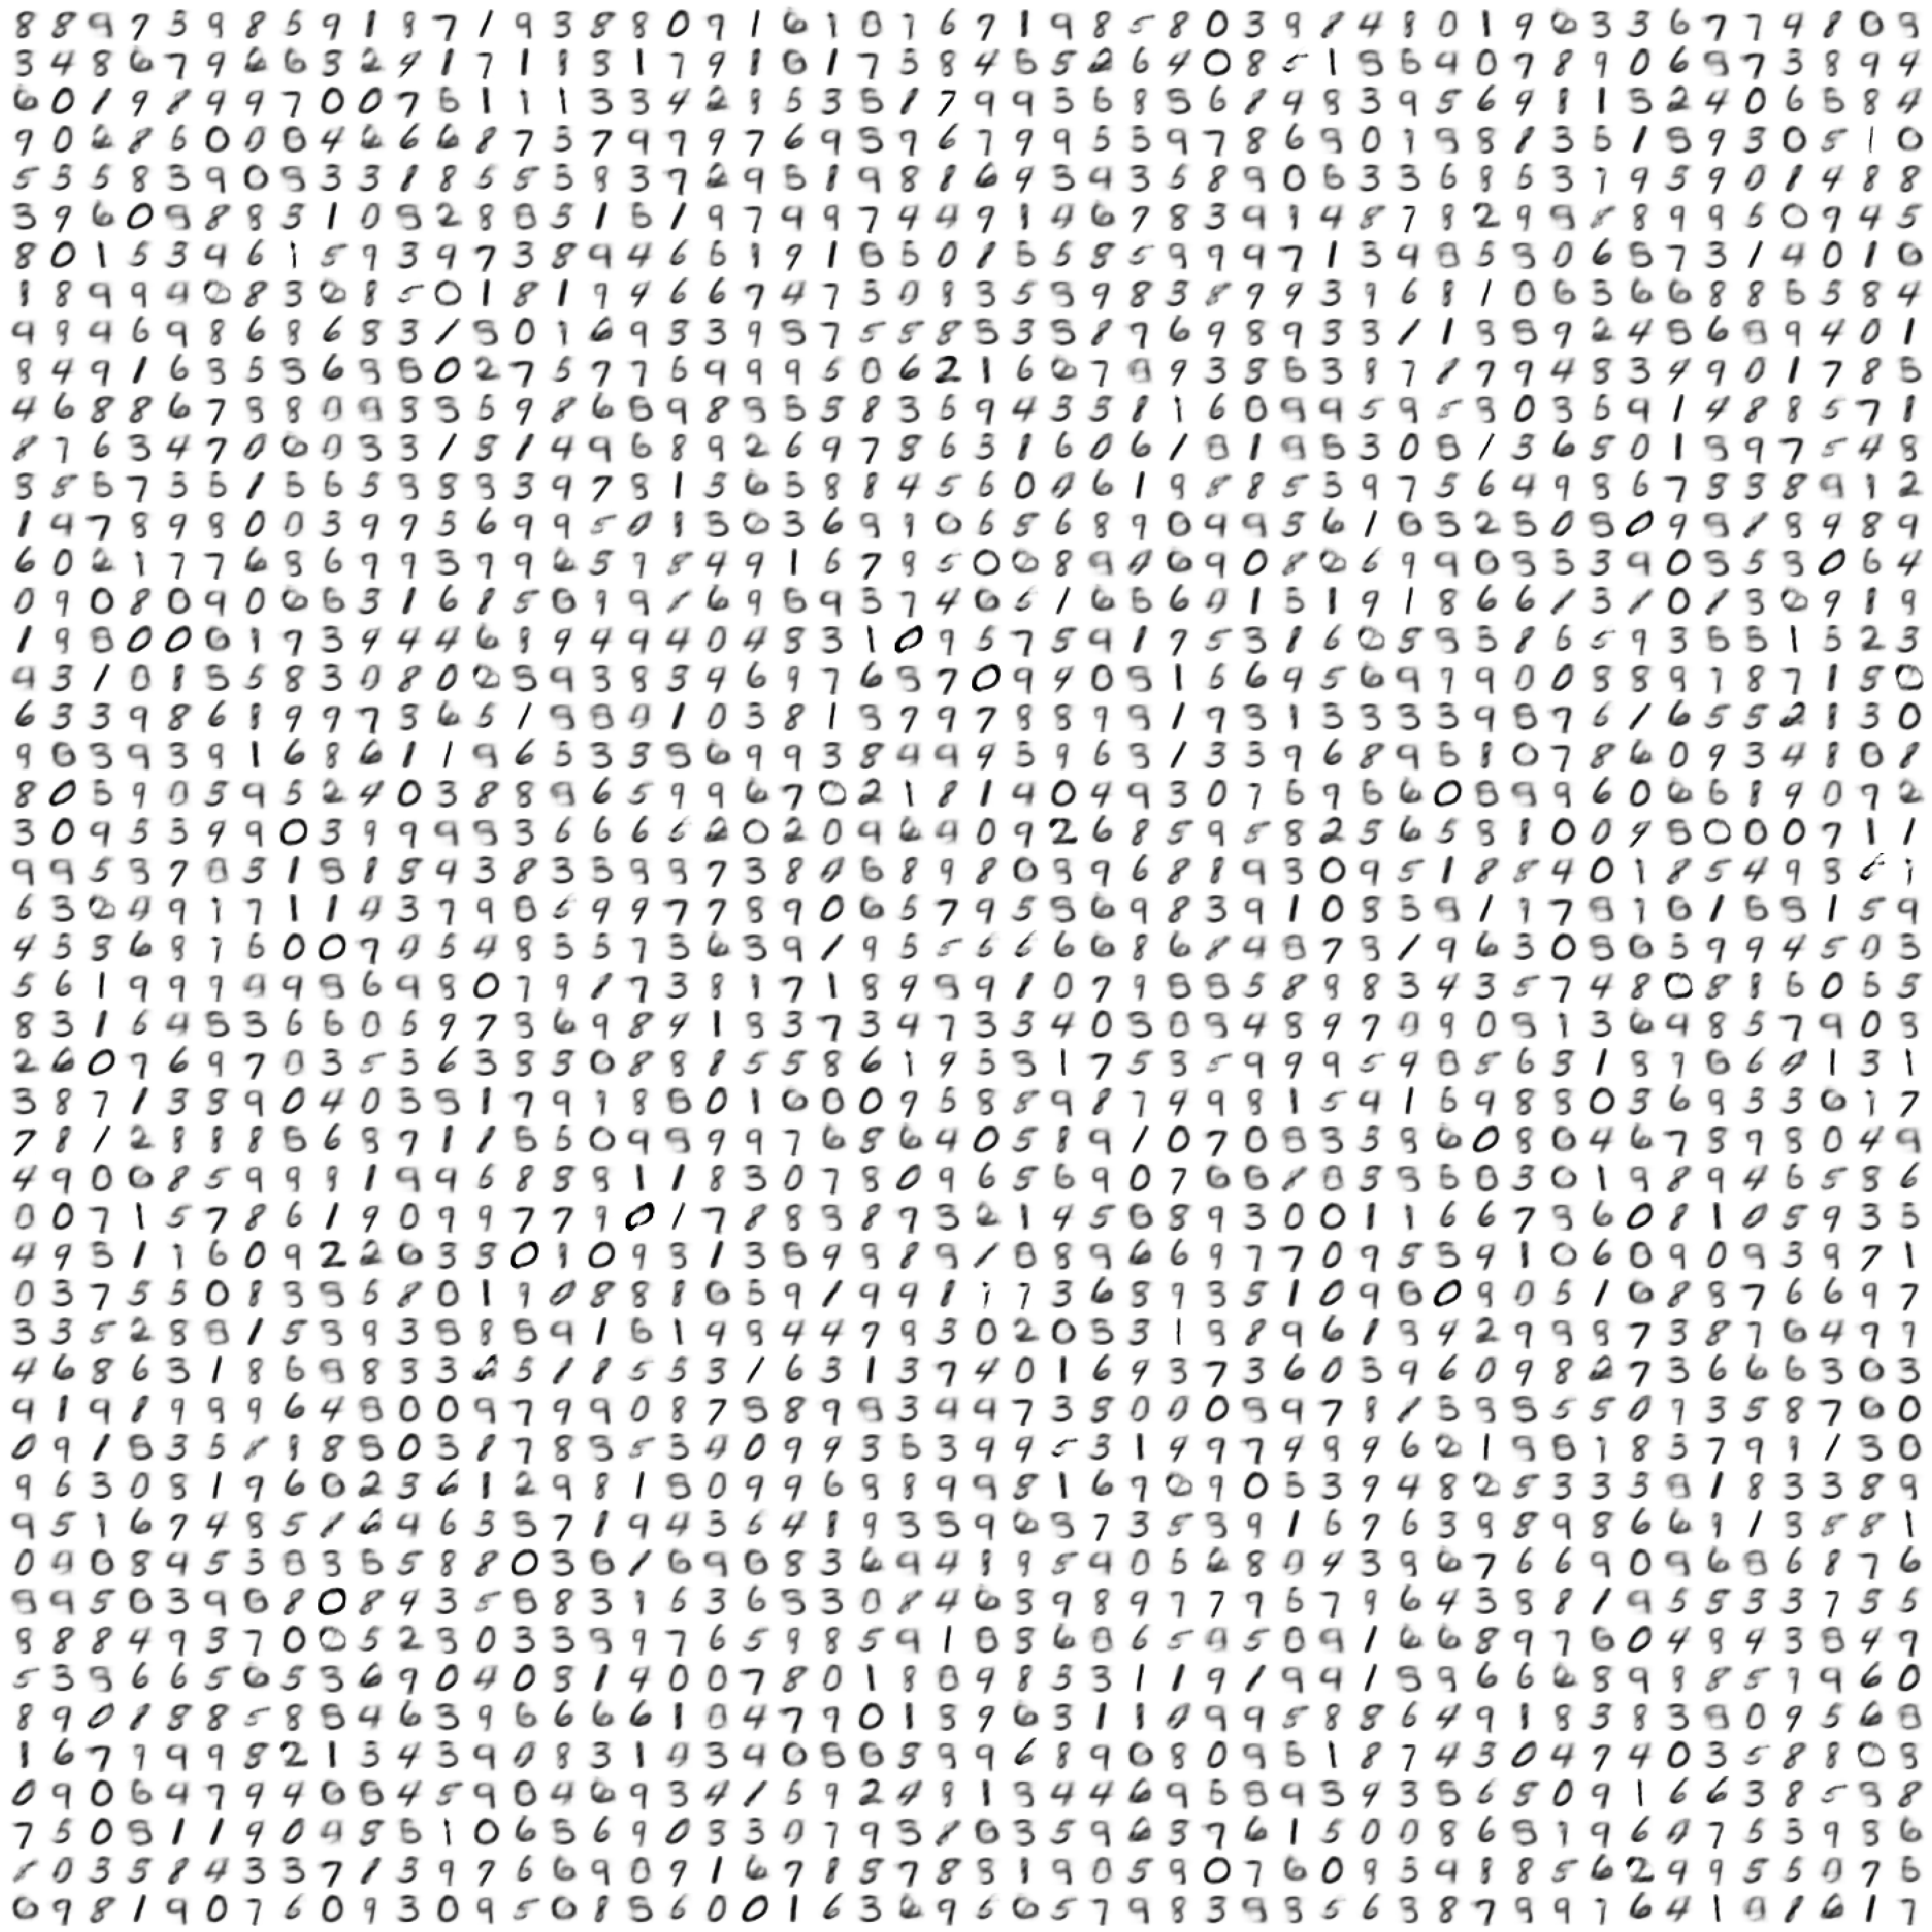

In [214]:
canvas = np.empty((28*n_samples, 28*n_samples))
for i, img in enumerate(images):
    x = i // n_samples
    y = i % n_samples
    canvas[(n_samples-y-1)*28:(n_samples-y)*28, x*28:(x+1)*28] = img.reshape(28, 28)
plt.figure(figsize=(40, 40))
plt.imshow(canvas, origin="upper", cmap="Greys")
plt.axis('off')
plt.tight_layout()
plt.show()

Grid scan 2D latent space

In [208]:
# plot latent space
if N_LATENT==2:
    n_pts = 20

    idx = np.arange(0, n_pts)

    x = np.linspace(norm.cdf(-3), norm.cdf(3),n_pts)
    x = ndtri(x)

    x_grid = np.array(np.meshgrid(*[i for i in np.matlib.repmat(x,n_latent,1)]))
    id_grid = np.array(np.meshgrid(*[i for i in np.matlib.repmat(idx,n_latent,1)]))

    zsamples = nd.array(x_grid.reshape((n_latent, -1)).transpose())
    zsamples_id = id_grid.reshape((n_latent, -1)).transpose()

    images = net2.decoder(zsamples.as_in_context(model_ctx)).asnumpy()

    # plot
    canvas = np.empty((28*n_pts, 28*n_pts))
    for i, img in enumerate(images):
        x, y = zsamples_id[i]
        canvas[(n_pts-y-1)*28:(n_pts-y)*28, x*28:(x+1)*28] = img.reshape(28, 28)
    plt.figure(figsize=(6, 6))
    plt.imshow(canvas, origin="upper", cmap="Greys")
    plt.axis('off')
    plt.tight_layout()
    plt.show()

AttributeError: module 'numpy' has no attribute 'matlib'

#### Visualizing latent space (when it is 2D)

In [211]:
n_batches = 10
counter = 0
results = []
labels = []
for batch in test:
    net2(batch.data[0].as_in_context(model_ctx))
    results.append(net2.mu.asnumpy()) # CHANGE THIS
    labels.append(batch.label[0].asnumpy())
    counter +=1
    if counter >= n_batches:
        break

# transform lists
result = np.vstack(results)
labels = np.hstack(labels)

LOSS: 
[240.36125  174.36298   50.465546  53.18766   45.093487 144.7104
 146.14107  165.79776  152.60414  171.00308  146.8323   195.55716
 146.94885  117.91009  115.18385  151.43211  139.4378   162.25023
 163.37106  169.68417  112.92834  211.79002  273.84213   88.45377
  49.319187 230.50113  177.06647  116.07784   51.062637  74.96747
 138.03825  153.46259  163.21404  176.14694   90.013306 128.37175
 185.29854  162.10225  119.74694   47.873924 151.5089   159.81984
 181.98366  172.77493  181.17148  201.26372  160.0479   204.7318
 141.47157  154.25383  140.9734    78.35446  114.94829  150.48082
  89.53333   95.768684 149.97725  130.18529  169.69131  202.98228
 173.5515   141.02554  119.8715    79.84938  146.99797   48.515373
 180.6269    57.6415   231.61667  202.35446  154.04384  144.14508
  49.84802  137.06819  143.87642  132.01494   42.228863 180.74779
 170.03752   44.53483  172.22     114.76784  116.735985 172.85077
 127.77651  191.93817  135.08888  202.51678   58.987103 162.2785
 172.

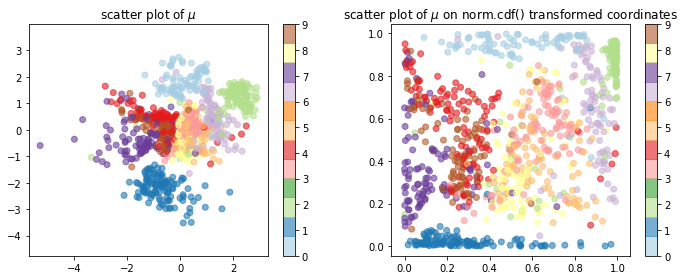

In [213]:
# plot latent space
if result.shape[1]==2:
    fig, axarr = plt.subplots(1,2, figsize=(10,4))
    im=axarr[0].scatter(result[:, 0], result[:, 1], c=labels, alpha=0.6, cmap='Paired')
    axarr[0].set_title(r'scatter plot of $\mu$')
    axarr[0].axis('equal')
    fig.colorbar(im, ax=axarr[0])

    im=axarr[1].scatter(norm.cdf(result[:, 0]), norm.cdf(result[:, 1]), c=labels, alpha=0.6, cmap='Paired')
    axarr[1].set_title(r'scatter plot of $\mu$ on norm.cdf() transformed coordinates')
    axarr[1].axis('equal')
    fig.colorbar(im, ax=axarr[1])
    plt.tight_layout()
    plt.show()